# Q3: Are there characteristics of a country that correlate with increases or decreases in the use of nuclear energy?

Notebook to analyse correlations of nuclear energy usage with economic and political indicators.

In [4]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import country_converter
cc = country_converter.CountryConverter()

from clean_data_after_merge import clean_data_after_merge
import plot_geopandas_interactive_map

### Loading, Selection and Cleaning of Data

In [11]:
data = pd.read_csv('../data/data_merged/data.csv')
data = clean_data_after_merge(data).set_index(['year','country']).sort_index()
data = data[
    [# economy
     'population','GDP','GDP growth', 'GDP per capita', 'GDP per capita growth',
     'income per capita', 'income per capita growth', 
     # political 
     'research_%GDP','representative_government', 'fundamental_rights',
     'checks_on_gouvernment', 'impartial_administration','civil_society_participation',
     'nuclear_warheads','accident_cost_MioUSD2013', 'accident_deaths',
     # nuclear energy 
     'built_reactors', 'shutdown_reactors', 'operating_reactors',
     'prod_btu', 'nuclear_prod_btu']
]
OECD = cc.OECDas('ISO3')['ISO3']
data = data.query("country in @OECD")

In [12]:
# function for cleaning, filtering and interpoation of missing values
def clean_data(data):
    data_cleaned = data.copy()
    
    # drop countries with many NaNs (more than 300 total)
    nans = data_cleaned.isna().sum(axis=1).sum(axis=0,level='country')
    countries = nans[nans<300].index 
    excluded = nans[nans>=300].index
    print('Excluded countries: ', cc.convert(excluded.to_list(), src='ISO3', to='short'))
    data_cleaned = data_cleaned.query('country in @countries')
    
    # fill production of nuclear energy with 0, if 'operating_reactors'==0 and 'nuclear_prod_btu'==NaN
    for year,country in data_cleaned.index:
        if (not data_cleaned['operating_reactors'].at[year,country].astype('bool')) and data['nuclear_prod_btu'].isna().at[year,country]:
            data_cleaned['nuclear_prod_btu'].at[year,country] = 0
    
    
    # interpolate per feature and country
    for column in data_cleaned.columns:
        if column in ['accident_cost_MioUSD2013','accident_deaths']: 
            data_cleaned[column] = data_cleaned[column].replace('No Accident',0)
        data_cleaned[column] = data_cleaned[column].unstack().interpolate().stack()
    
    return data_cleaned

data_cleaned = clean_data(data)

# print shapes and NAN-count
print('\nDATA: \t',data.shape, data.isna().sum().sum(),
      '\nCLEANED:', data_cleaned.shape, data_cleaned.isna().sum().sum())

Excluded countries:  []

DATA: 	 (1443, 21) 1940 
CLEANED: (1443, 21) 1720


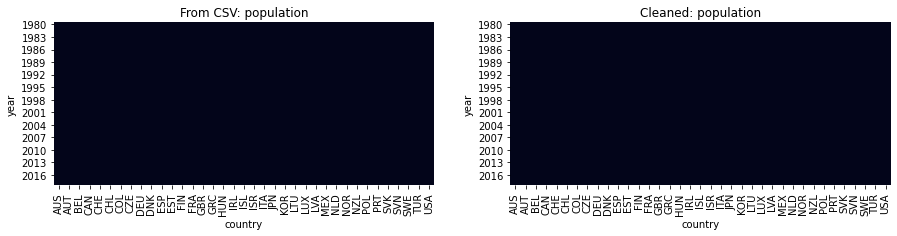

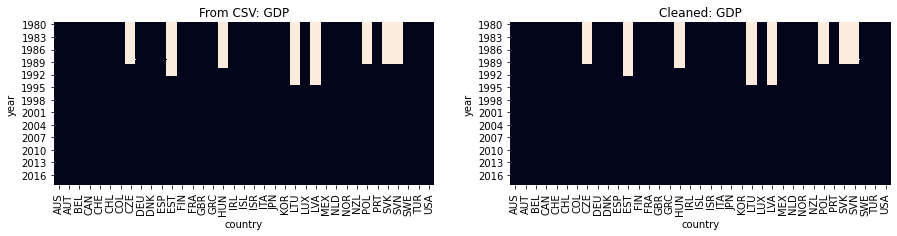

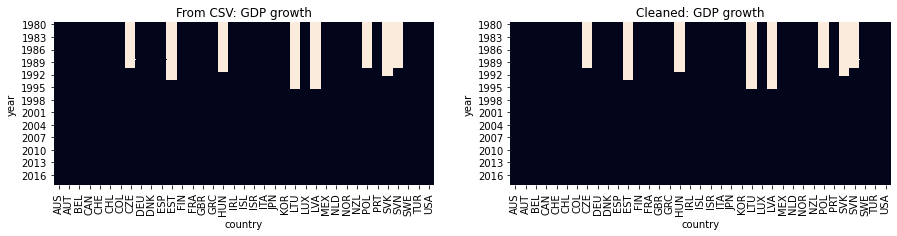

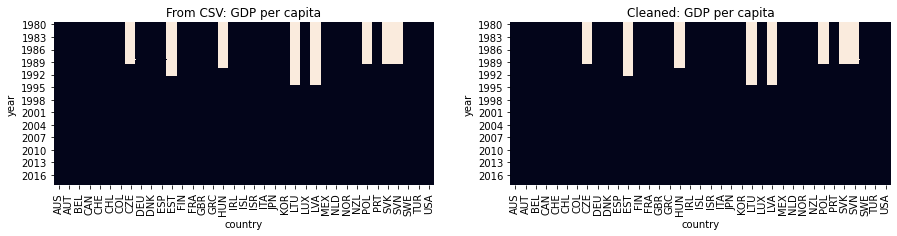

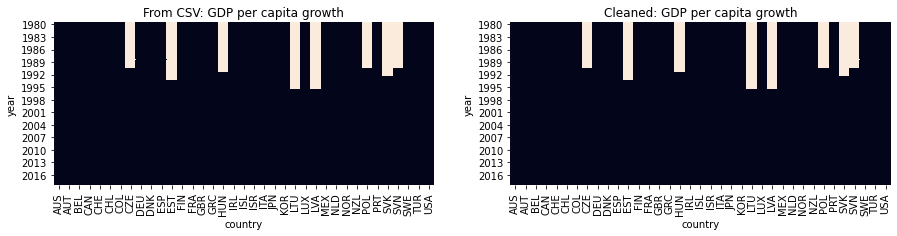

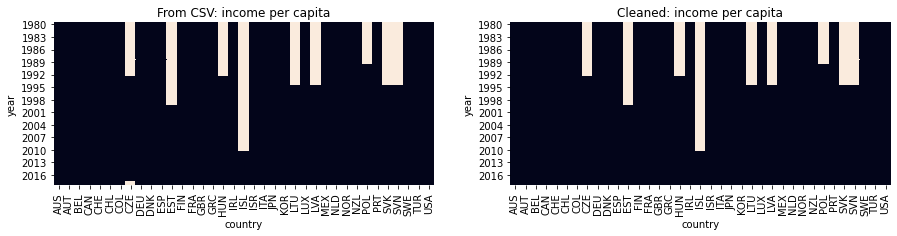

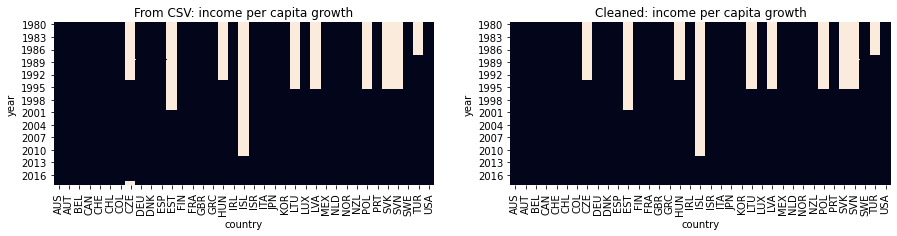

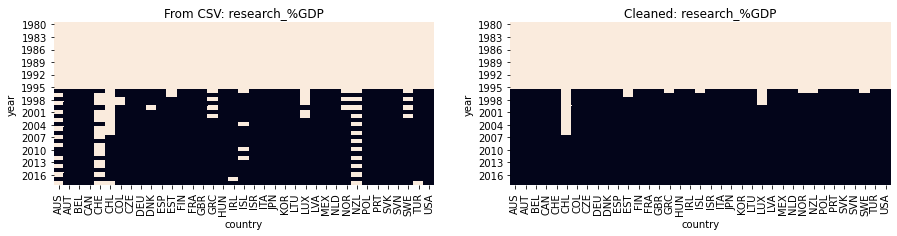

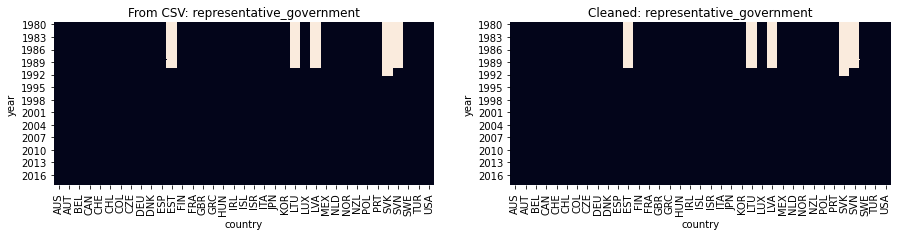

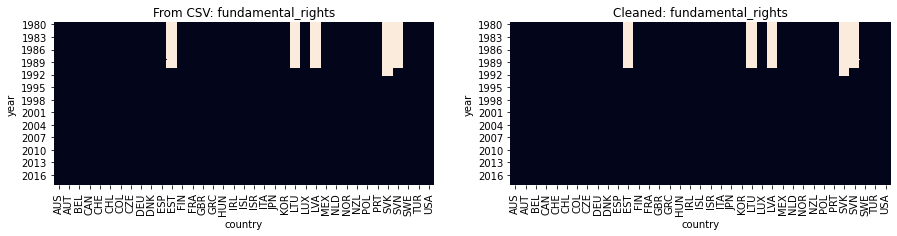

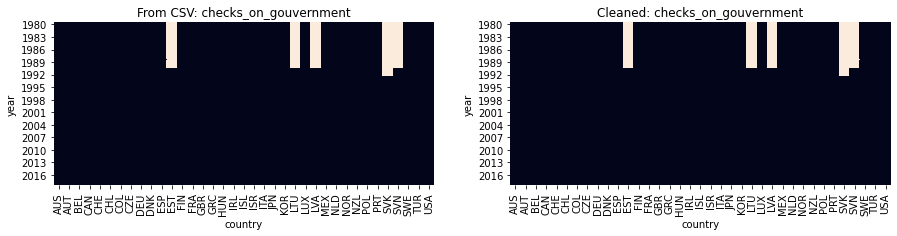

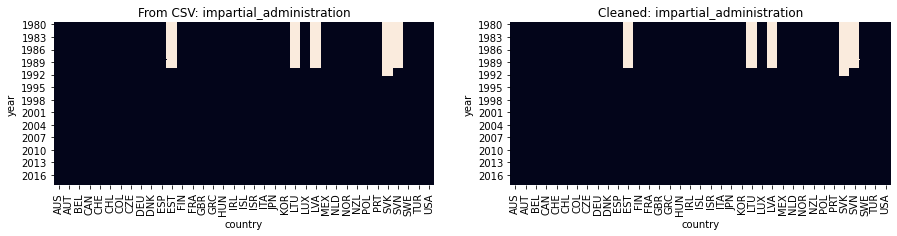

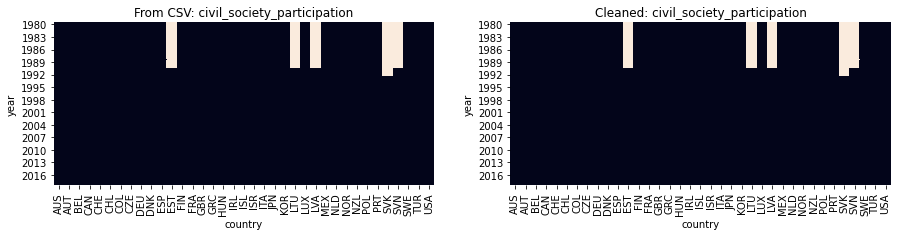

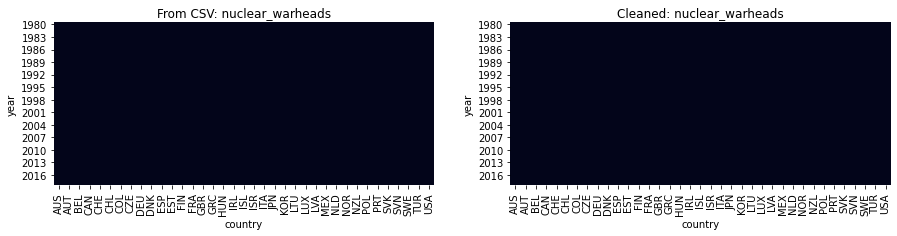

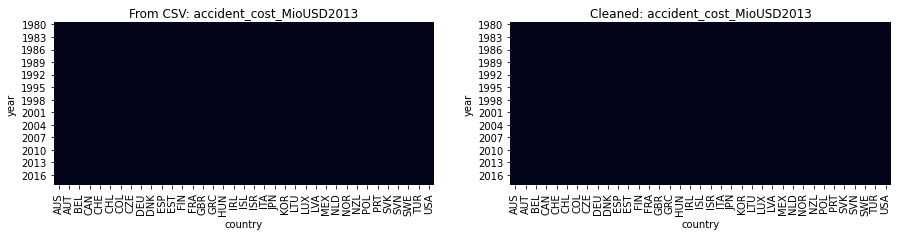

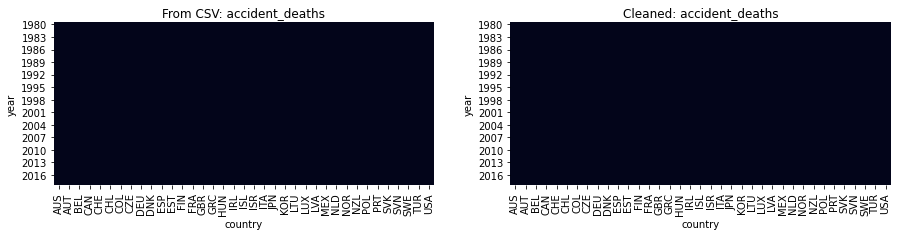

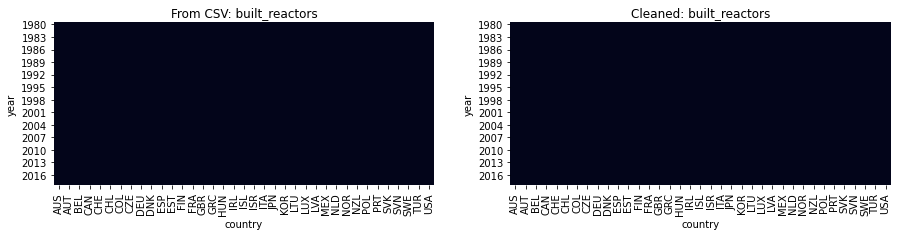

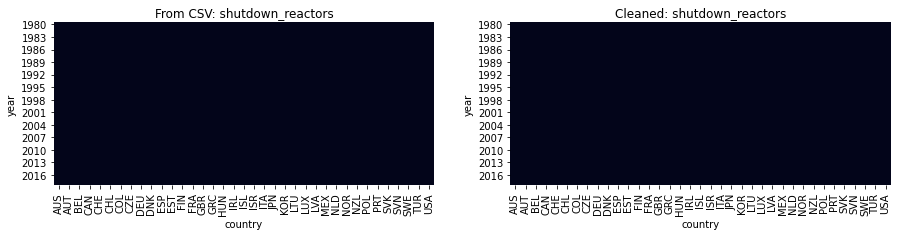

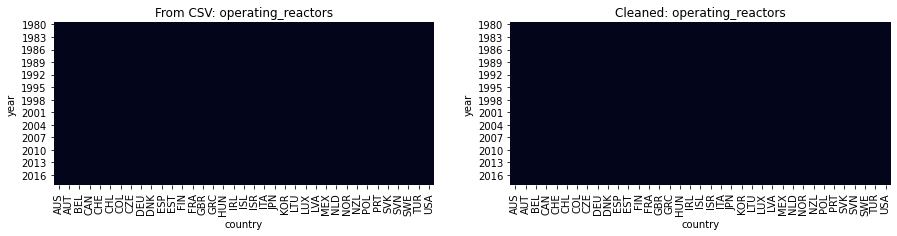

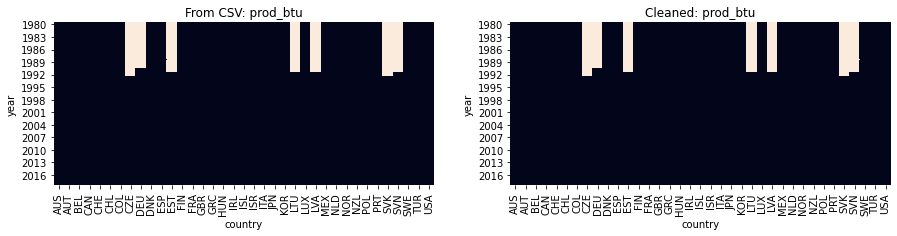

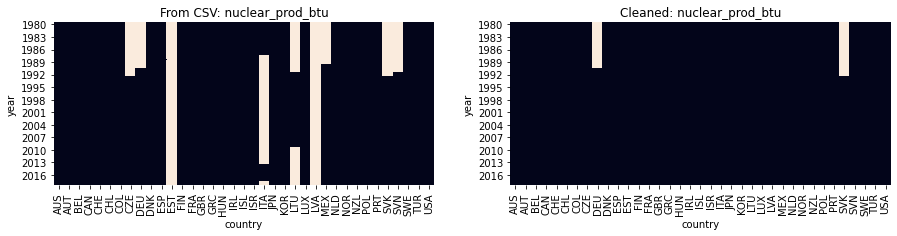

In [13]:
# heatmaps of missing data compared for initial and cleand data
for i,column in enumerate(data.columns):
    plt.figure(figsize=[15,3])
    plt.subplot(121)
    sns.heatmap(data[column].unstack().isna(), vmin=0, vmax=1, cbar=False)
    plt.title('From CSV: ' + column)
    plt.subplot(122)
    sns.heatmap(data_cleaned[column].unstack().isna(), vmin=0, vmax=1, cbar=False)
    plt.title('Cleaned: ' + data_cleaned.columns[i])
    plt.show()

In [14]:
# total missing values per column
pd.concat([data.isna().sum().rename('NaNs in CSV'), data_cleaned.isna().sum().rename('NaNs in Cleaned data')], axis=1)

NaNs in CSV  NaNs in Cleaned data
population                             0                     0
GDP                                   94                    94
GDP growth                           104                   104
GDP per capita                        94                    94
GDP per capita growth                104                   104
income per capita                    148                   147
income per capita growth             170                   169
research_%GDP                        671                   614
representative_government             57                    57
fundamental_rights                    57                    57
checks_on_gouvernment                 57                    57
impartial_administration              57                    57
civil_society_participation           57                    57
nuclear_warheads                       0                     0
accident_cost_MioUSD2013               0                     0
accident_deaths                        0                     0
built_reactors                         0                     0
shutdown_reactors                      0                     0
operating_reactors                     0                     0
prod_btu                              85                    85
nuclear_prod_btu                     185                    24

#### ANNUAL Correlation for Change of nuclear-energy-use with country properties

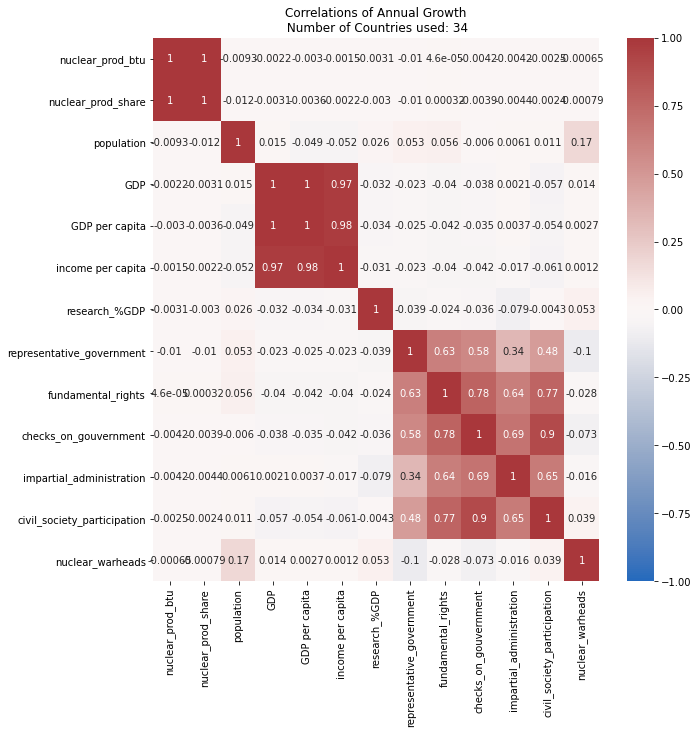

In [23]:
def correlation_q3_single_year(start=1980, end=2018, nuclear_countries_only=True):
    data = pd.read_csv('./data/data_merged/data.csv').set_index(['year','country'])
    # exclude countries, that do not use nuclear energy (in both years)
    if nuclear_countries_only:
        nuclear_countries = data['operating_reactors'].sum(axis=0, level='country').replace(0,np.nan).dropna().index
        data = data.query("country in @nuclear_countries")
    
    # select columns
    data_amount = data[['nuclear_prod_btu', 'population','GDP','GDP per capita','income per capita','research_%GDP',
                        'representative_government','fundamental_rights','checks_on_gouvernment',
                        'impartial_administration','civil_society_participation','nuclear_warheads']]
    
    # calculate ANNUAL growth (relative change of two succeeding years)
    data_growth = pd.DataFrame()
    for column in data_amount.columns:
        data_growth[column] = data_amount[column].unstack().pct_change().stack()
    
    # restrict time range
    data_growth = data_growth.query("@start <= year <= @end")
    
    # fill missing values with 0 and drop infinities
    data_growth = data_growth.fillna(0)
    data_growth = data_growth.replace(np.inf,np.nan).dropna()
    
    # make plot
    %matplotlib inline
    plt.figure(figsize=[10,10])
    sns.heatmap(data_growth.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')
    plt.title(f'Correlations of Annual Growth' + 
              f'\n Number of Countries used: {data_growth.index.get_level_values("country").drop_duplicates().size}')
    plt.show()
    
    return data_growth

df = correlation_q3_single_year(start=1998, end=2018, nuclear_countries_only=True)

6

### Calculate and Select Features

In [17]:
data_amount = data_cleaned[[
    'GDP per capita', 'income per capita', 'representative_government', 'fundamental_rights',
    'checks_on_gouvernment', 'impartial_administration','civil_society_participation', 'nuclear_warheads',
    'accident_cost_MioUSD2013', 'accident_deaths', 'built_reactors','shutdown_reactors', 'operating_reactors']]
data_amount.insert(2, 'research_%GDP_per_capita', data_cleaned['research_%GDP'])
data_amount['nuclear_prod_btu'] = data_cleaned['nuclear_prod_btu']
data_amount['nuclear_prod_share'] = data_cleaned['nuclear_prod_btu'].divide(data_cleaned['prod_btu'])

<ipython-input-17-544d9625881c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_amount['nuclear_prod_btu'] = data_cleaned['nuclear_prod_btu']
<ipython-input-17-544d9625881c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_amount['nuclear_prod_share'] = data_cleaned['nuclear_prod_btu'].divide(data_cleaned['prod_btu'])


In [18]:
data_growth = pd.DataFrame()
data_growth['GDP per capita growth'] = data_cleaned['GDP per capita growth']
data_growth['income per capita growth'] = data_cleaned['income per capita'].unstack().pct_change().stack()
data_growth['research_%GDP_per_capita_growth'] = data_amount['research_%GDP_per_capita'].unstack().pct_change().stack()
for column in ['representative_government', 'fundamental_rights', 'checks_on_gouvernment', 
               'impartial_administration','civil_society_participation', 'nuclear_warheads',
               'nuclear_warheads', 'built_reactors','shutdown_reactors', 'operating_reactors']:
    data_growth[column+'_growth'] = data_cleaned[column].unstack().pct_change().stack()
data_growth['accident_cost_MioUSD2013'] = data_cleaned['accident_cost_MioUSD2013']
data_growth['accident_deaths'] = data_cleaned['accident_deaths']
data_growth['nuclear_prod_btu_growth'] = data_amount['nuclear_prod_btu'].unstack().pct_change().stack()
data_growth['nuclear_prod_share_growth'] = data_amount['nuclear_prod_share'].unstack().diff().stack()

In [19]:
display(data_amount.isna().sum().sort_values())
display(data_growth.isna().sum().sort_values())

nuclear_warheads                 0
accident_cost_MioUSD2013         0
accident_deaths                  0
built_reactors                   0
shutdown_reactors                0
operating_reactors               0
nuclear_prod_btu                24
representative_government       57
fundamental_rights              57
checks_on_gouvernment           57
impartial_administration        57
civil_society_participation     57
nuclear_prod_share              85
GDP per capita                  94
income per capita              147
research_%GDP_per_capita       614
dtype: int64

accident_cost_MioUSD2013                 0
accident_deaths                          0
fundamental_rights_growth               94
checks_on_gouvernment_growth            94
impartial_administration_growth         94
civil_society_participation_growth      94
representative_government_growth       103
GDP per capita growth                  104
nuclear_prod_share_growth              122
income per capita growth               184
research_%GDP_per_capita_growth        651
built_reactors_growth                  698
operating_reactors_growth              735
nuclear_prod_btu_growth                758
shutdown_reactors_growth               964
nuclear_warheads_growth               1299
dtype: int64

## Visualisation

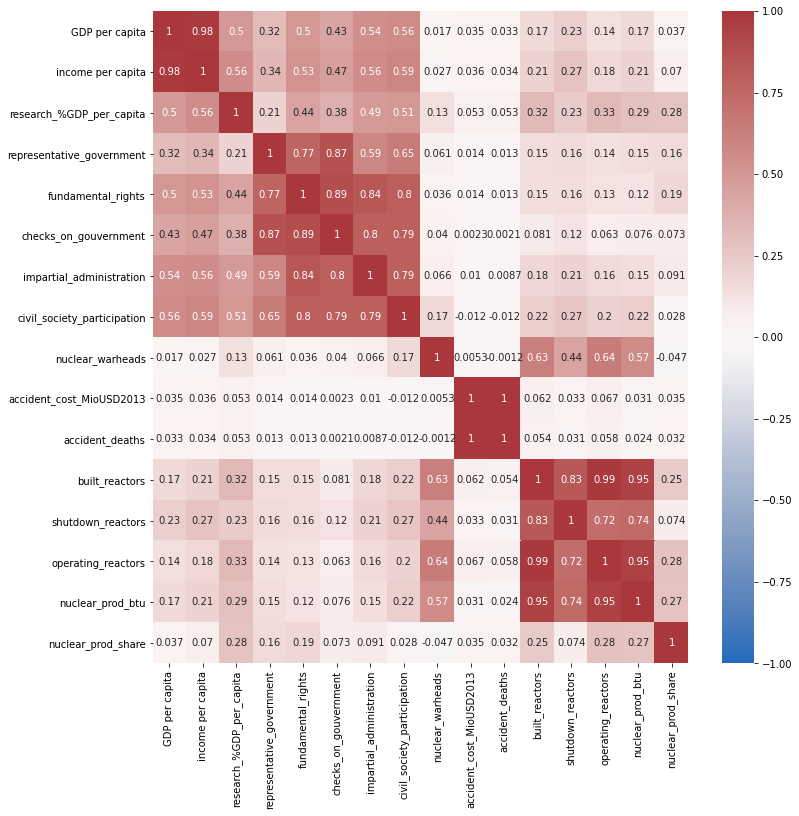

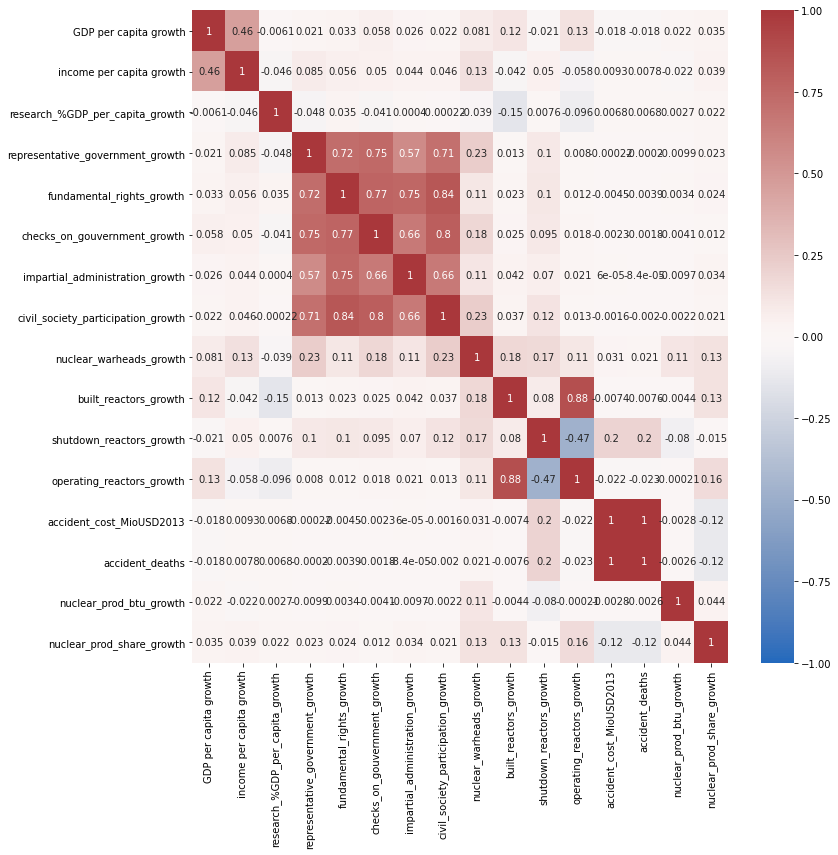

In [20]:
plt.figure(figsize=[12,12])
sns.heatmap(data_amount.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')
plt.show()
plt.figure(figsize=[12,12])
sns.heatmap(data_growth.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')
plt.show()

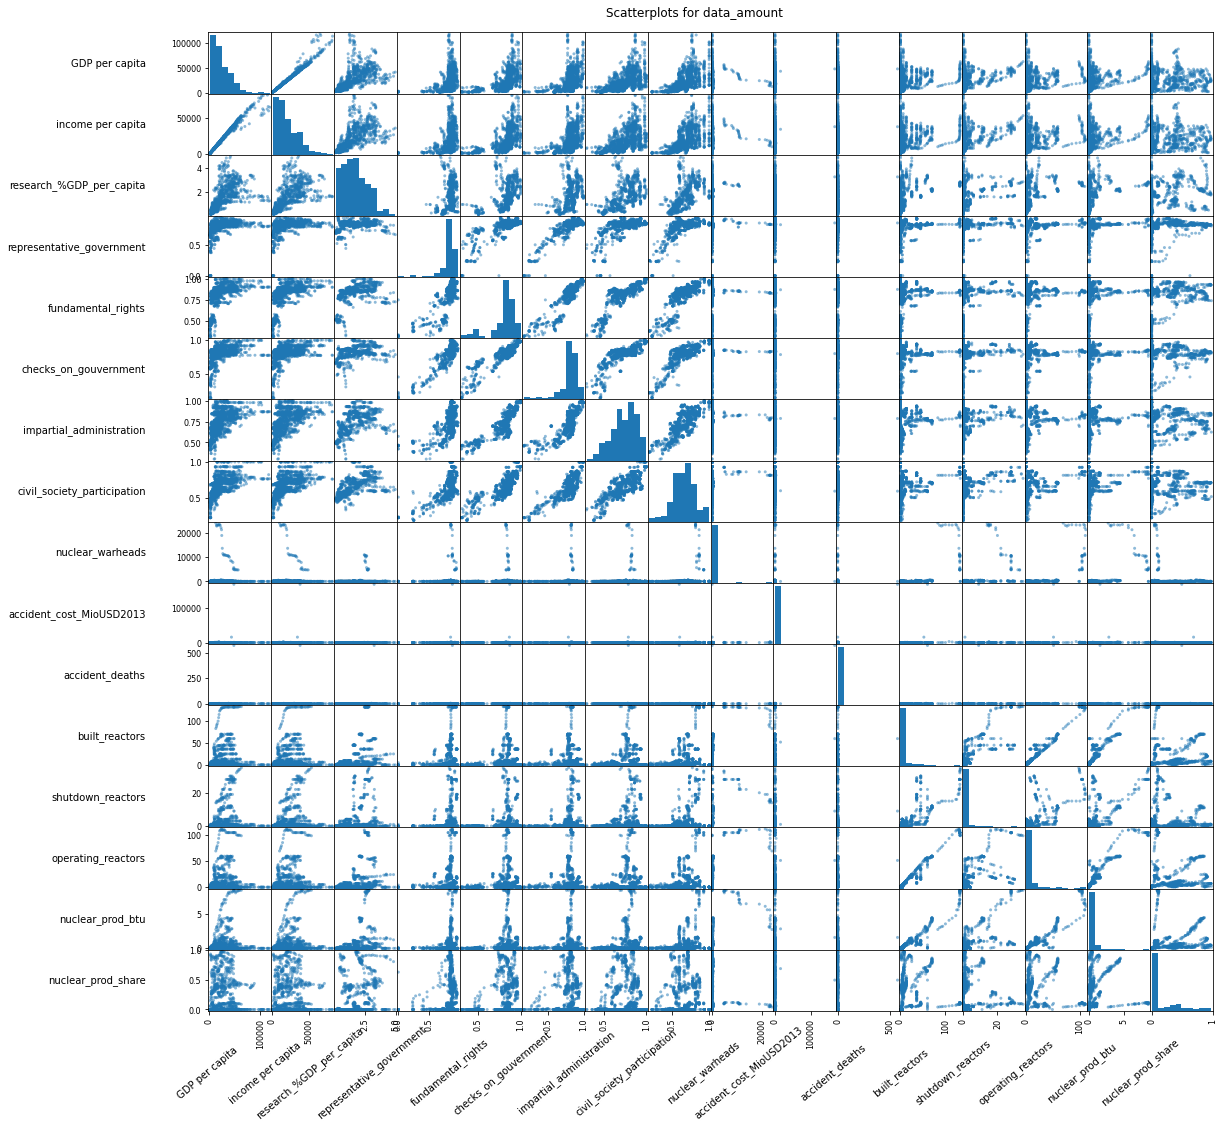

In [21]:
sm = pd.plotting.scatter_matrix(data_amount, figsize=(18, 18), diagonal='hist')
for s in sm.reshape(-1):
    s.xaxis.label.set_rotation(40)
    s.yaxis.label.set_rotation(0)
    s.xaxis.label.set_horizontalalignment('right')
    s.yaxis.label.set_horizontalalignment('right')
    s.xaxis.label.set_verticalalignment('center')
    s.yaxis.label.set_verticalalignment('center')
    s.get_yaxis().set_label_coords(-1,0.5)
    s.get_xaxis().set_label_coords(0.5,-1)
plt.suptitle('Scatterplots for data_amount', position=(0.5,0.9))
plt.show()

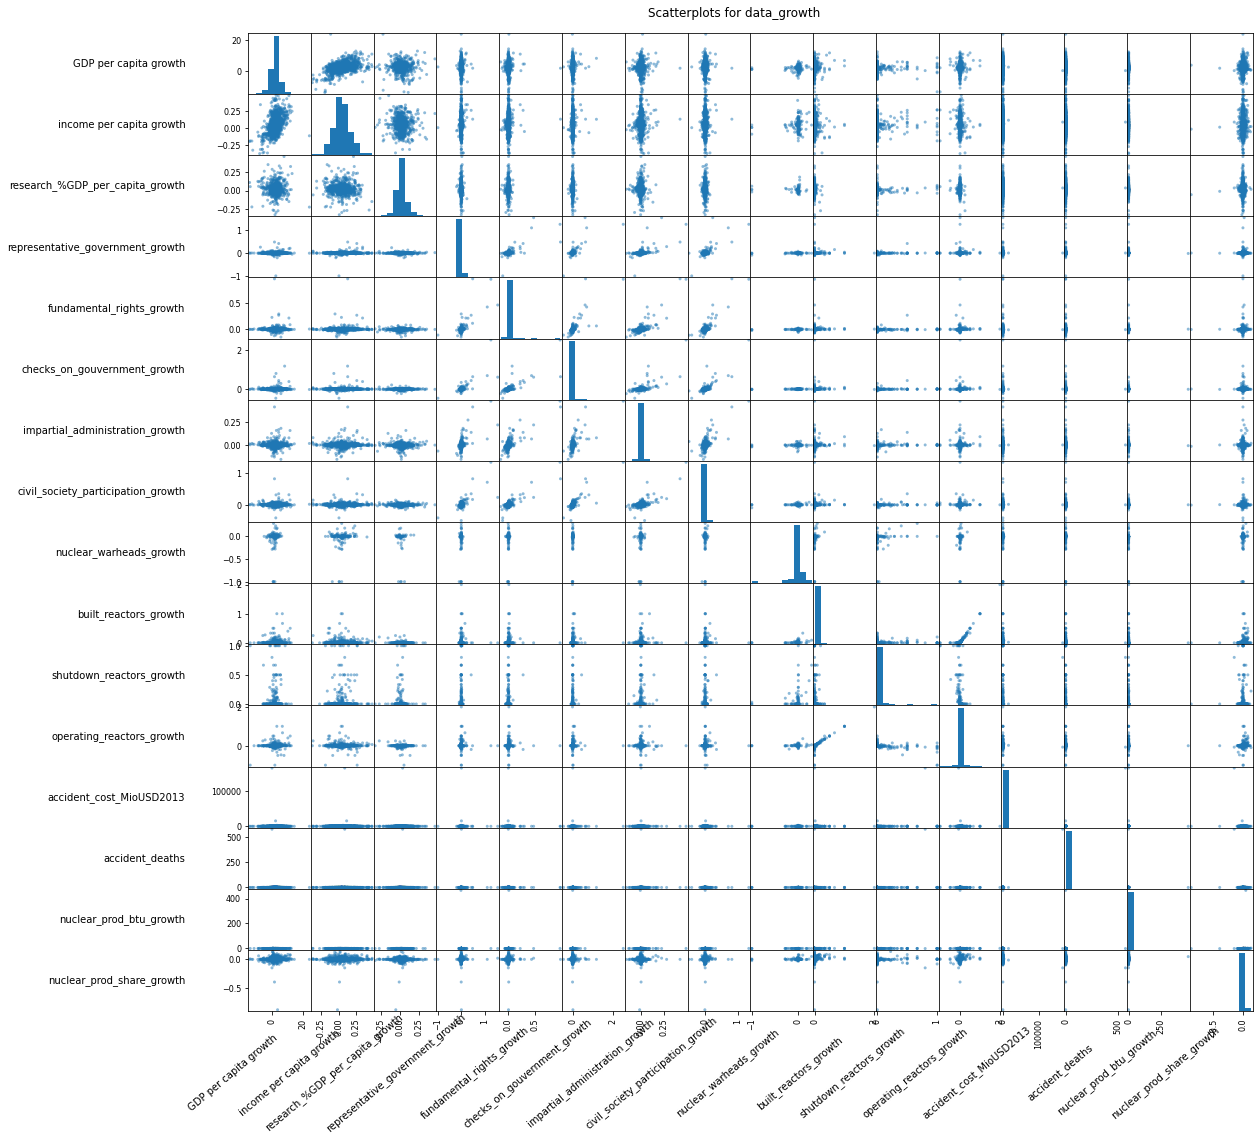

In [22]:
sm = pd.plotting.scatter_matrix(data_growth.replace({np.inf:np.nan}), figsize=(18, 18), diagonal='hist')
for s in sm.reshape(-1):
    s.xaxis.label.set_rotation(40)
    s.yaxis.label.set_rotation(0)
    s.xaxis.label.set_horizontalalignment('right')
    s.yaxis.label.set_horizontalalignment('right')
    s.xaxis.label.set_verticalalignment('center')
    s.yaxis.label.set_verticalalignment('center')
    s.get_yaxis().set_label_coords(-1,0.5)
    s.get_xaxis().set_label_coords(0.5,-1)
plt.suptitle('Scatterplots for data_growth', position=(0.5,0.9))
plt.show()

In [27]:
data_amount['nuclear_prod_share'].dropna().sort_values()

year  country
1980  AUS        0.000000
1996  LUX        0.000000
      LVA        0.000000
      NOR        0.000000
      NZL        0.000000
                   ...   
      BEL        0.969401
1998  BEL        0.969520
1993  BEL        0.972098
1997  BEL        0.974206
1992  LTU        0.978916
Name: nuclear_prod_share, Length: 1358, dtype: float64

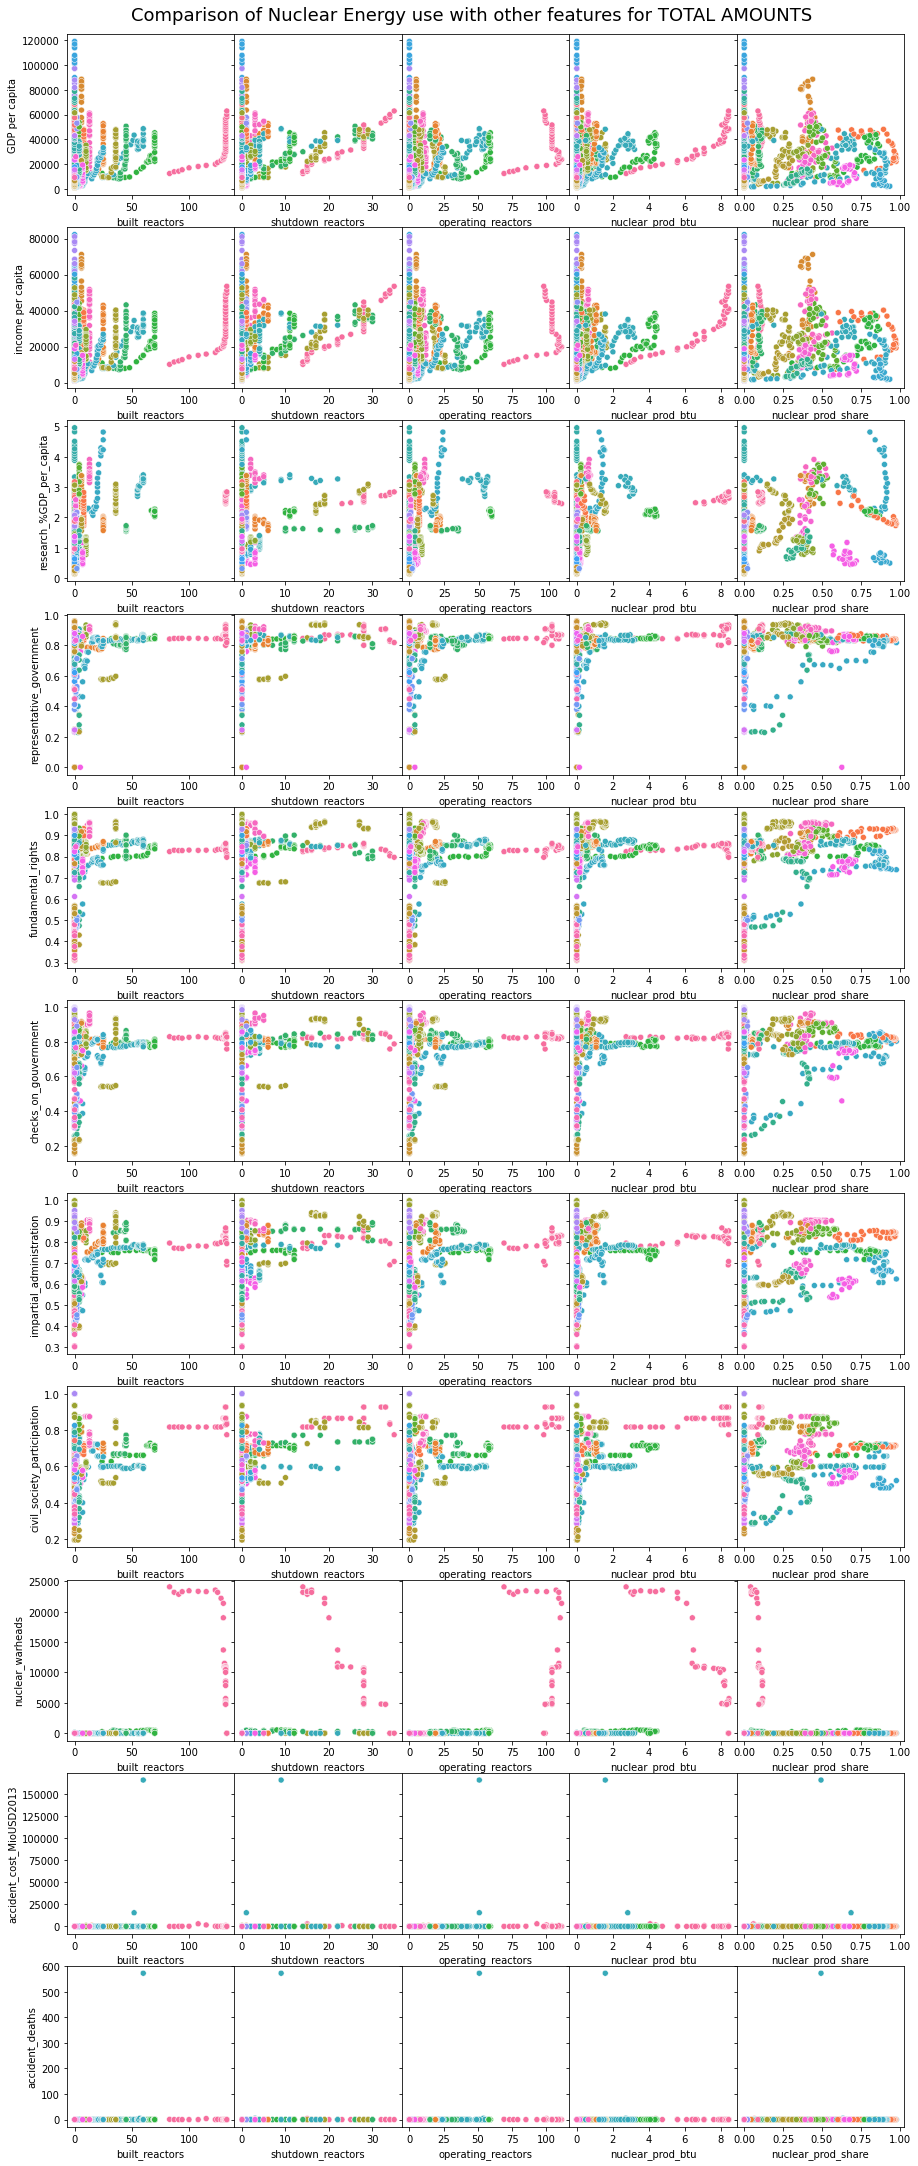

In [25]:
fig,ax = plt.subplots(len(data_amount.columns)-5,5, figsize=[15,3.5*(len(data_amount.columns)-5)], 
                      sharey='row', sharex=False, gridspec_kw=dict(wspace=0))
plt.suptitle('Comparison of Nuclear Energy use with other features for TOTAL AMOUNTS', position=(0.5,0.89), fontsize=18)
for i,column in enumerate(data_amount.columns[:-5]):
    for j,column2 in enumerate(data_amount.columns[-5:]):
        sns.scatterplot(ax=ax[i,j],
            x=data_amount[column2], y=data_amount[column],
            hue=data_amount.index.get_level_values('country'), legend=None)#'full')
plt.show()

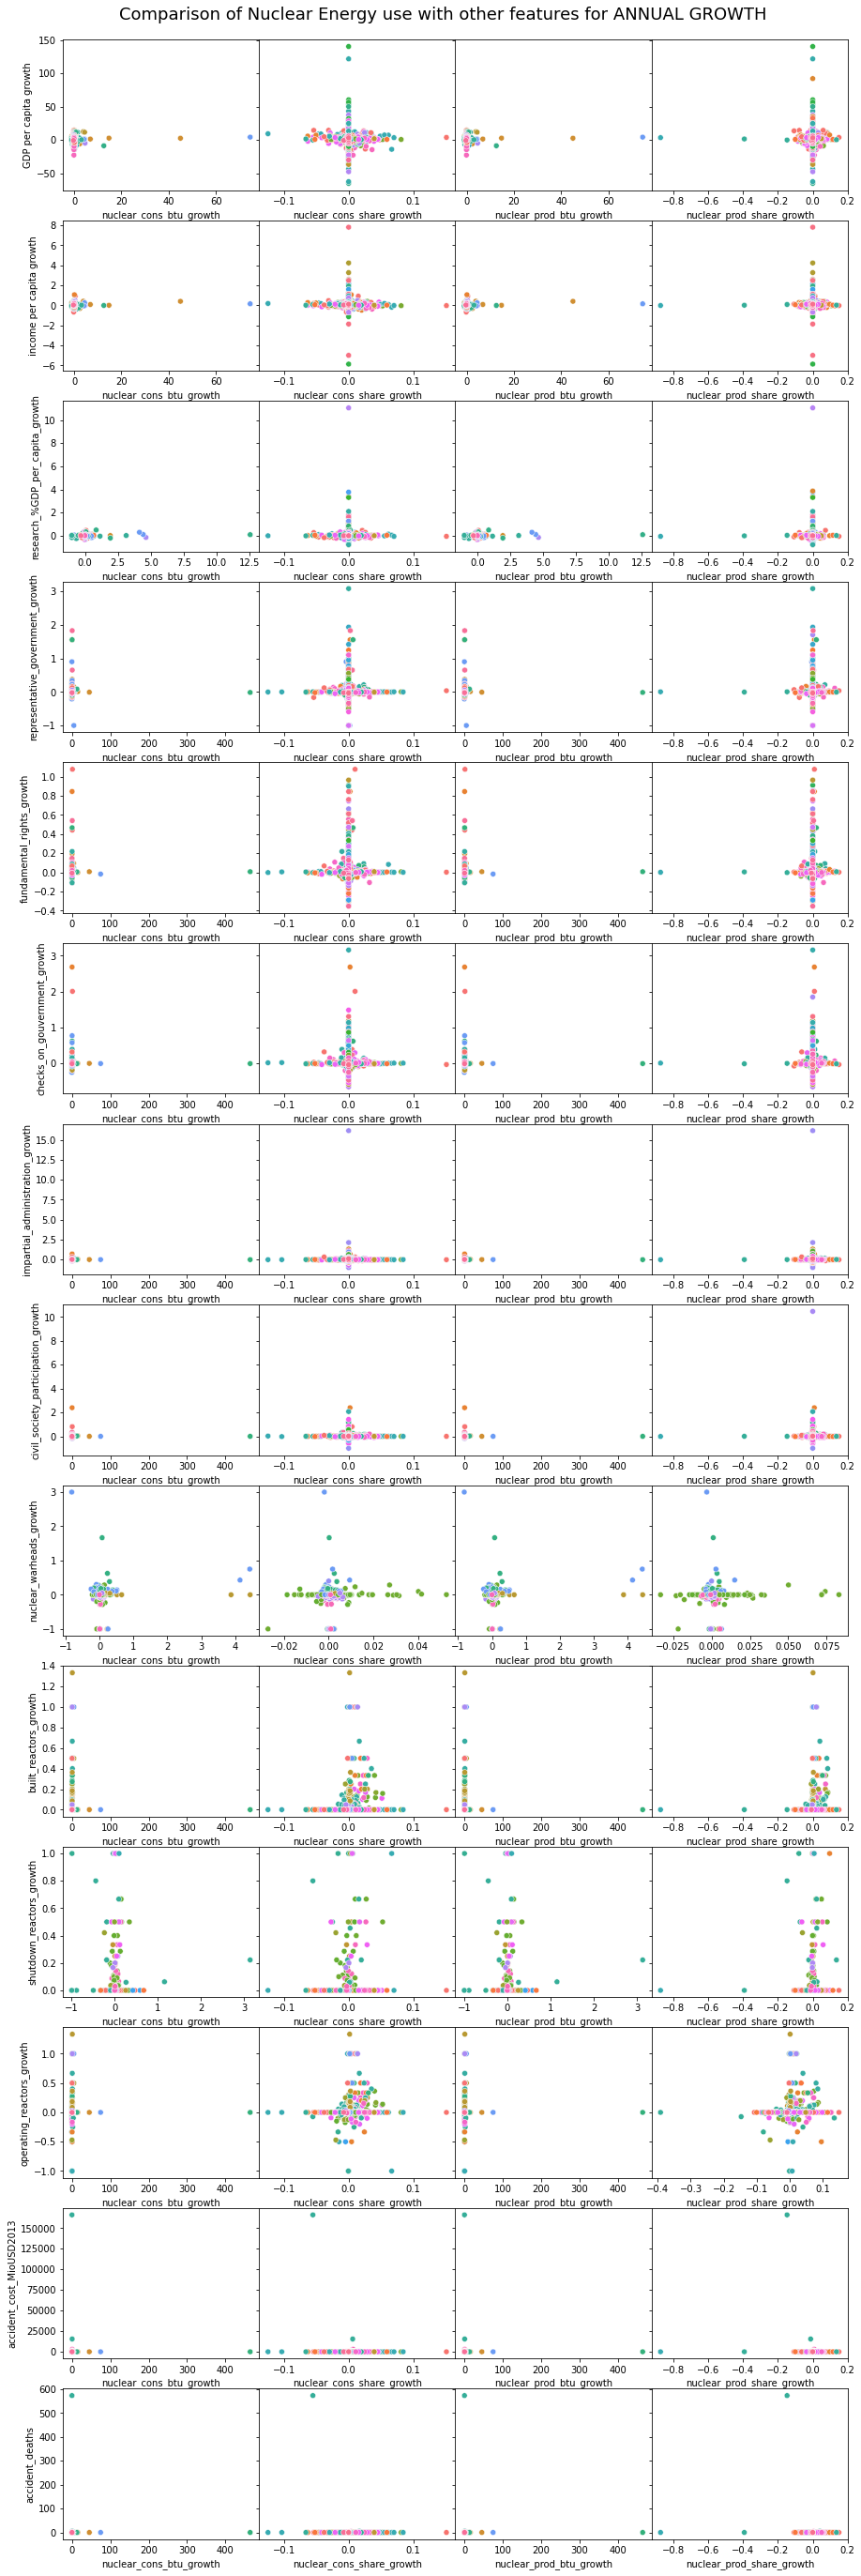

In [14]:
fig,ax = plt.subplots(len(data_growth.columns)-4,4, figsize=[15,3.5*(len(data_growth.columns)-4)], 
                      sharey='row', sharex=False, gridspec_kw=dict(wspace=0))
plt.suptitle('Comparison of Nuclear Energy use with other features for ANNUAL GROWTH', position=(0.5,0.89), fontsize=18)
for i,column in enumerate(data_growth.columns[:-4]):
    for j,column2 in enumerate(data_growth.columns[-4:]):
        sns.scatterplot(ax=ax[i,j],
            x=data_growth[column2], y=data_growth[column],
            hue=data_growth.index.get_level_values('country'), legend=None)#'full')
plt.show()

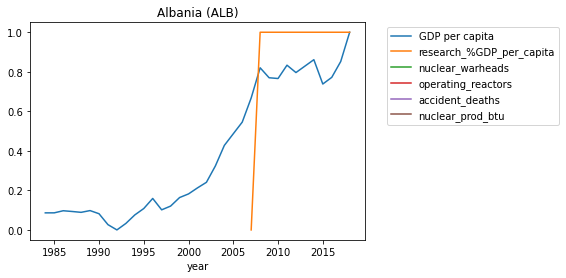

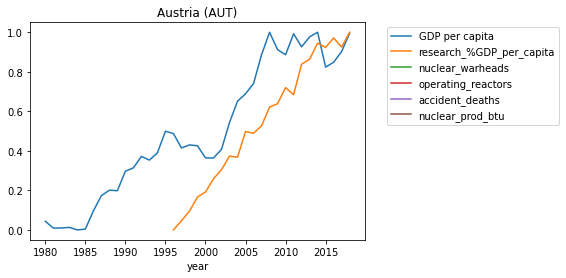

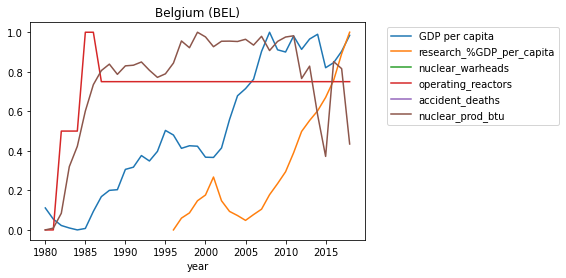

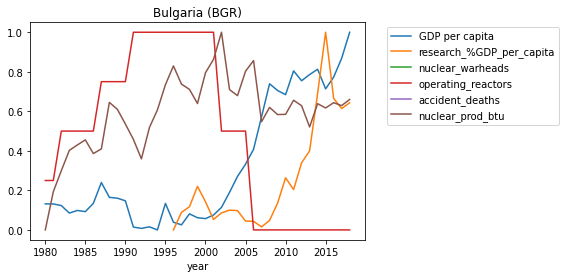

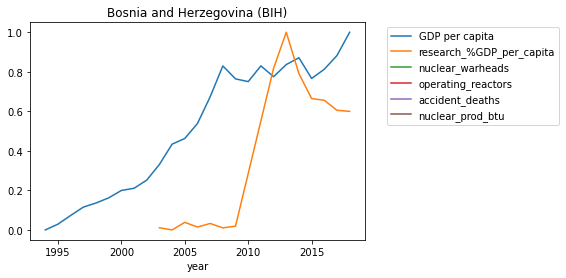

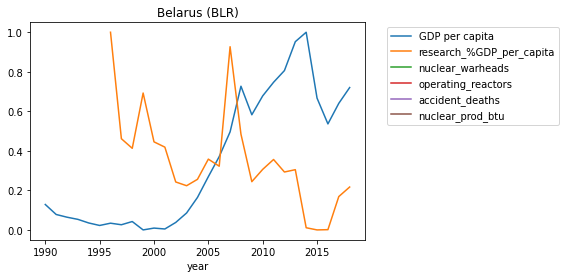

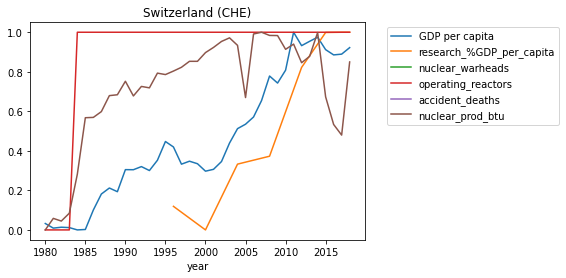

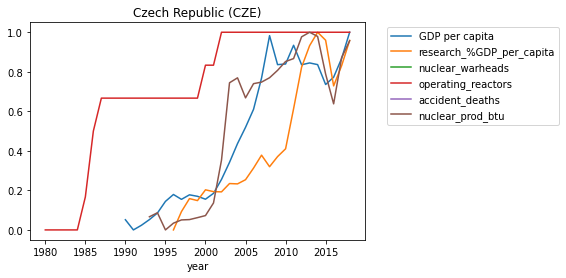

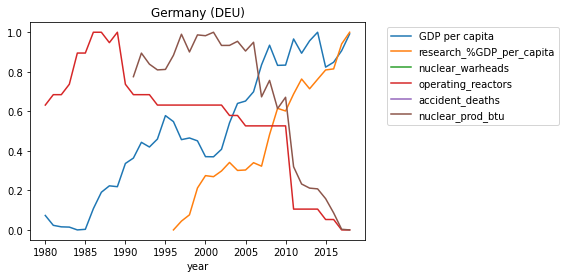

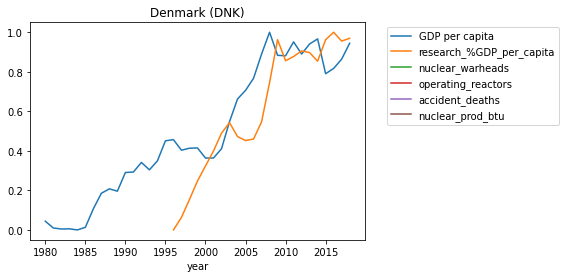

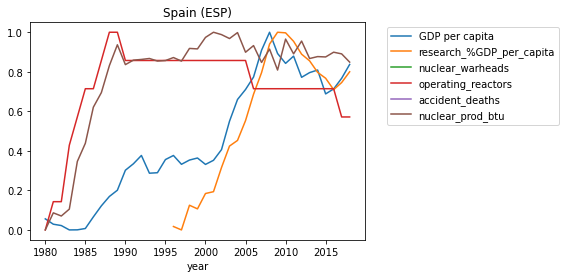

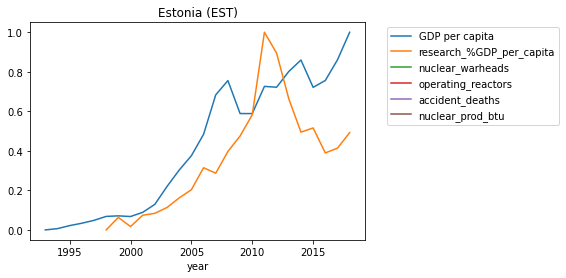

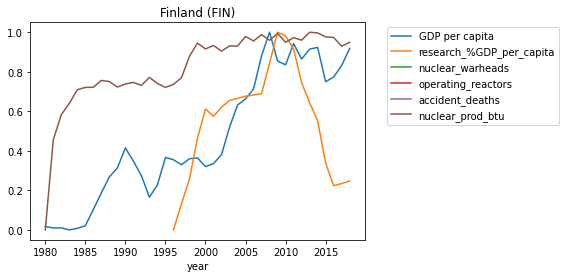

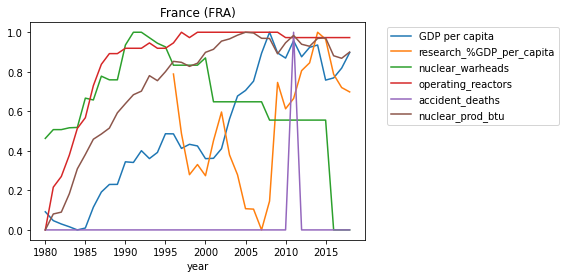

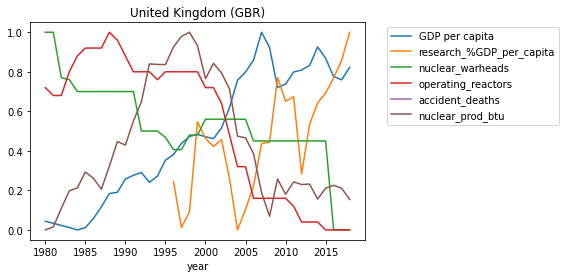

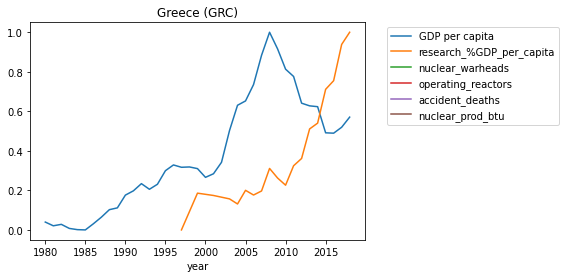

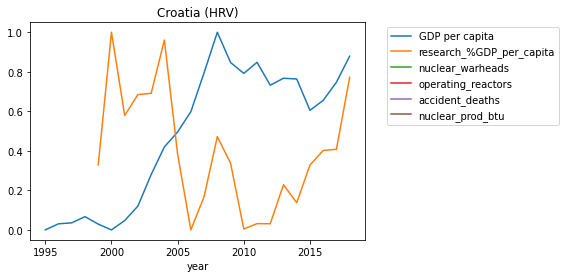

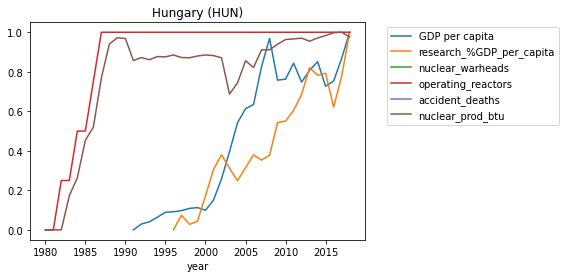

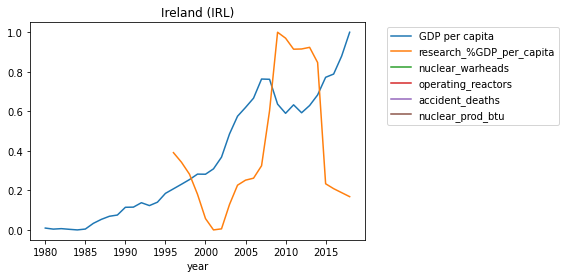

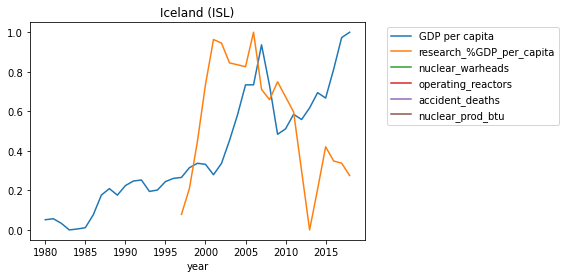

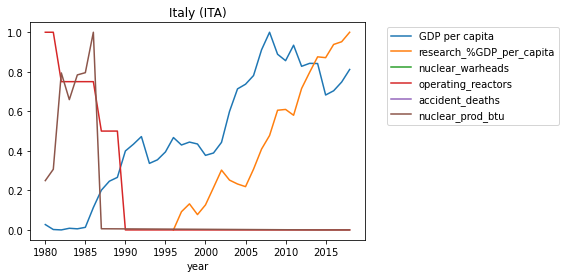

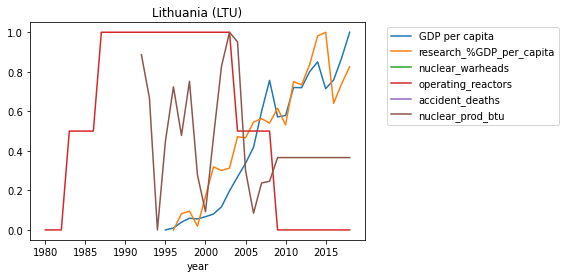

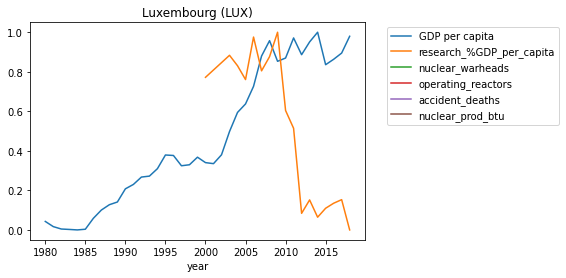

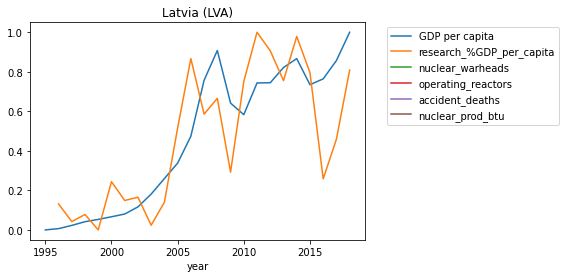

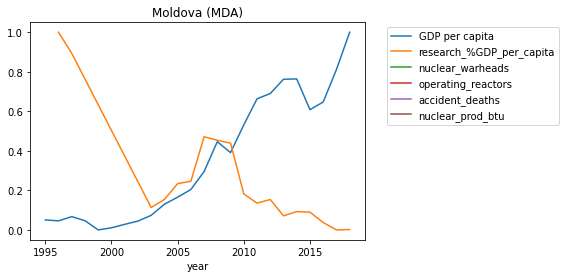

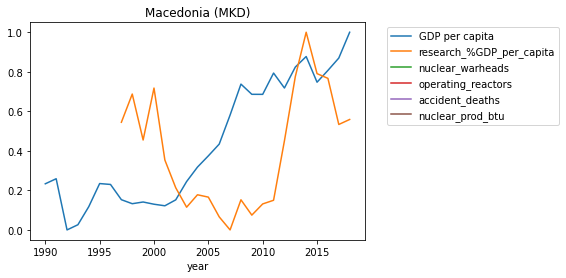

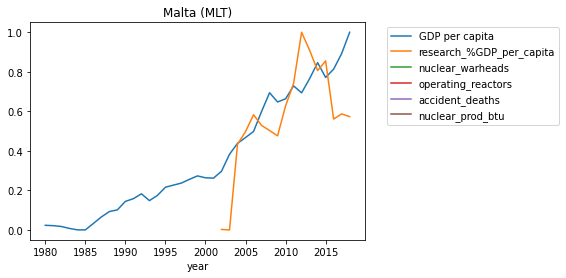

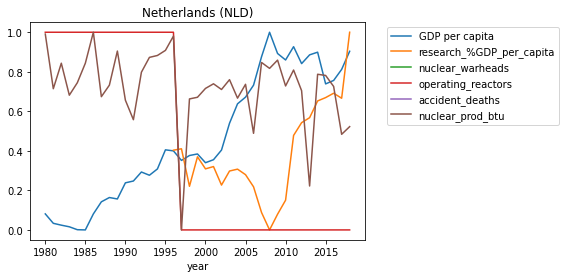

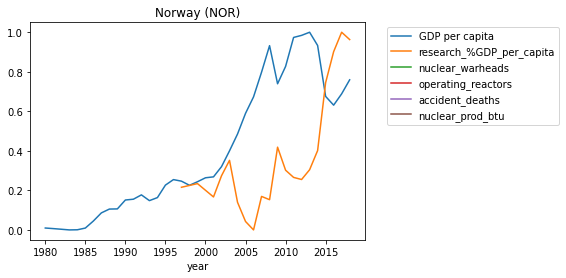

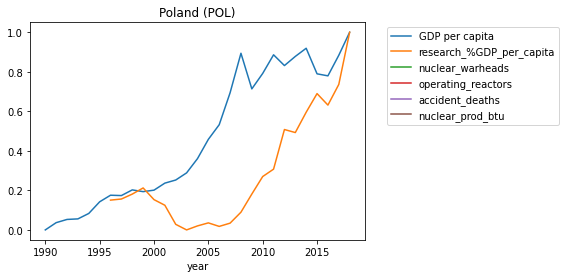

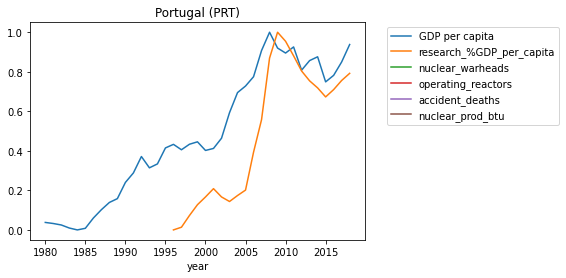

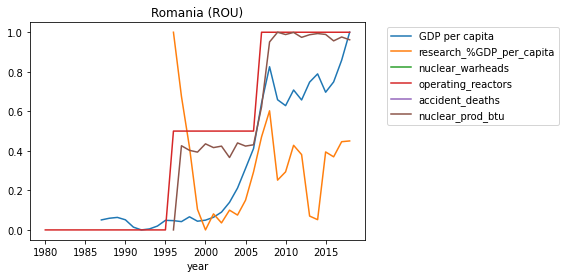

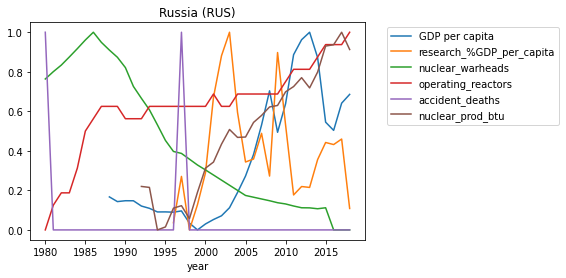

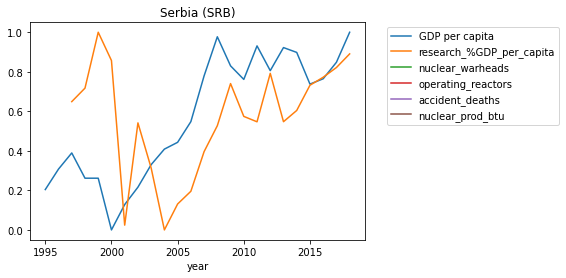

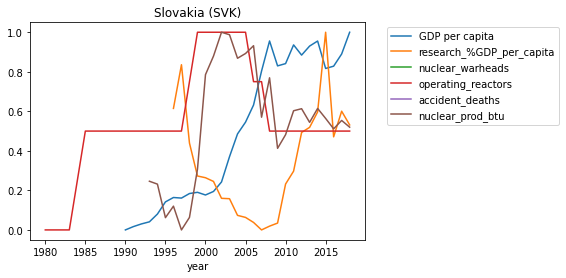

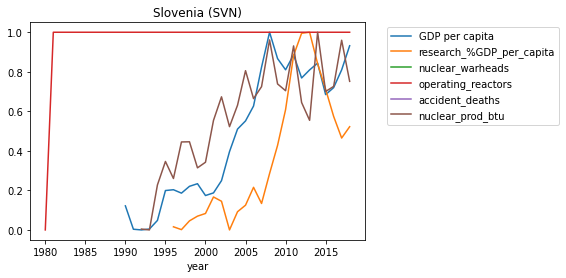

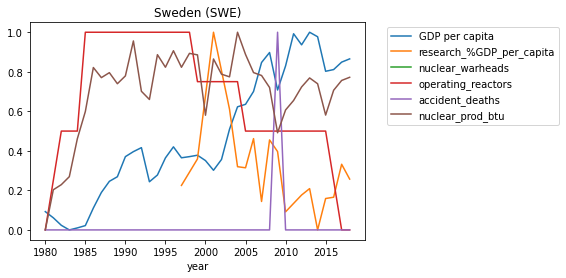

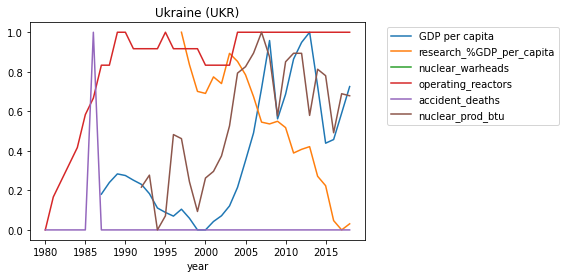

In [15]:
for i,country in enumerate(data_amount.index.get_level_values('country').drop_duplicates()):
    # PLOT ONLY OECD COUNTRIES
    #if country in cc.OECDas('ISO3')['ISO3'].to_list():
    # PLOT ONLY IF IN EUROPE
    if cc.continentas('ISO3').query("ISO3 == @country")['continent'].values=='Europe':
        columns = ['GDP per capita','research_%GDP_per_capita', 'nuclear_warheads','operating_reactors','accident_deaths','nuclear_prod_btu']
        df = data_amount.xs(country, level='country')[columns]
        normalized_df=(df-df.min())/(df.max()-df.min())
        normalized_df.plot()#legend=None)
        plt.title(cc.convert(country, src='ISO3', to='short') + ' (' + country + ')')
        #if i%5==0: 
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

### Comparing calulated GDP growth with data provided from source

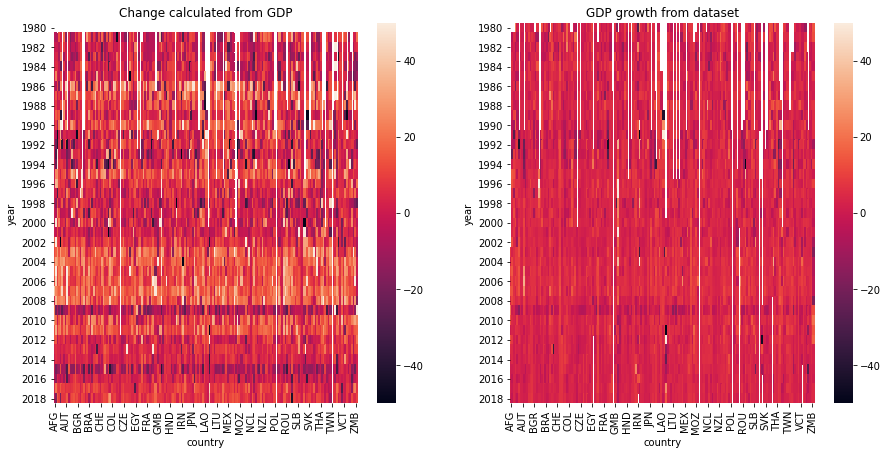

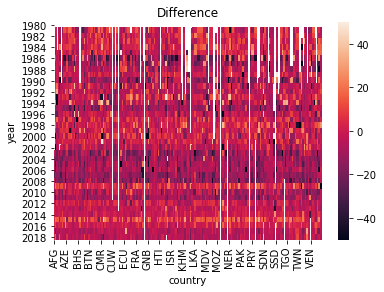

In [16]:
%matplotlib inline
plt.figure(figsize=[15,7])
plt.subplot(121)
sns.heatmap(data['GDP'].unstack().pct_change()*100, vmin=-50, vmax=50)
plt.title('Change calculated from GDP')
plt.subplot(122)
sns.heatmap(data['GDP growth'].unstack(), vmin=-50, vmax=50)
plt.title('GDP growth from dataset')
plt.show()

plt.figure()
sns.heatmap(
    data['GDP growth'].unstack().subtract(data['GDP'].unstack().pct_change()*100)
    , vmin=-50, vmax=50)
plt.title('Difference')
plt.show()

test = data['GDP growth'].unstack().subtract(data['GDP'].unstack().pct_change()*100)

#### Plot other features with binary classification (YES/NO) over time

In [1]:
def plot_featue(data, feature, title=None):    
    if title==None: title=feature.upper()

    df = pd.DataFrame(index=data.index)
    df['is nuclear'] = data[feature][data['BOOL']]
    df['not nuclear'] = data[feature][~data['BOOL']]
    
    fig, ax = plt.subplots(1,2, figsize=[15,5])
    
    df_plot = df.mean(axis=0, level='year')
    df_plot.plot(ax=ax[0])
    ax[0].set_ylabel(feature + " (average of countries)")
    ax[0].set_xlim(df_plot.index.min(),df_plot.index.max())
    ax[0].set_ylim(0)
    ax[0].set_title('Worldwide', fontsize=14)
    
            
    OECD = cc.OECDas('ISO3')['ISO3']
    df_plot = df.query("country in @OECD").mean(axis=0, level='year')
    df_plot.plot(ax=ax[1])
    ax[1].set_ylabel(feature + " (average of countries)")
    ax[1].set_xlim(df_plot.index.min(),df_plot.index.max())
    ax[1].set_ylim(0)
    ax[1].set_title('OECD-countries', fontsize=14)
    
    fig.suptitle(title, fontsize=16)
    return None

for feature in ['population','GDP','GDP per capita','income per capita','research_%GDP','representative_government','fundamental_rights',
                'checks_on_gouvernment','impartial_administration','civil_society_participation','nuclear_warheads',
                ]:
    plot_featue(data_cleaned, feature)

NameError: name 'data_cleaned' is not defined

#### On which continents are the countries, that have operating nuclear reactors?

In [ ]:
cc.continentas('ISO3').query("continent in @continent")

In [ ]:
def plot_by_continents():
    df = dict()
    for continent in cc.continent['continent'].drop_duplicates():
        countries = cc.continentas('ISO3').query("continent in @continent")['ISO3']
        df[continent] = data.query("country in @countries")
    
    return df 
        
test = plot_by_continents()
for key in test.keys():
    display(test[key])